# Projet IF29 P22
### Détection des influenceurs sur Twitter en appliquant les méthodes non supervisée et supervisée

In [ ]:
# Créer la BD en utilisant le fichier 'Worldcup 200Tweets' sur moodle
from pymongo import MongoClient
import os
import json

client = MongoClient('localhost', 27017)
db = client['______'] # nom de BD
collection = db['______'] #nom de collection
parent_dir = ("_____________________________________") #adresse de fichier
list_filename = os.listdir(parent_dir)

for filename in list_filename:
    filepath = parent_dir + filename
    with open(filepath, encoding='utf-8') as f:
        lines = f.readlines()
        f.close()
    for line in lines:
        document = json.loads(line[:-1])
        collection.insert_one(document)

In [2]:
# Connecter à la BD
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['if29_projet']
collection = db['if29_projet']

In [3]:
# Créer le dataframe en utilisant les attributs qui nous intéressent concernant les utilisateurs
import numpy as np
import pandas as pd

cursor = collection.aggregate(
    [
        {"$group" : {
            "_id" : "$user.id", 
            "friends_count" : {"$last" : "$user.friends_count"},
            "favourites_count" : {"$last" : "$user.favourites_count"},
            "statuses_count" : {"$last" : "$user.statuses_count"},
            "followers_count" : {"$last" : "$user.followers_count"},
             "created_time" : {"$last" : "$user.created_at"}
        }
        }
    ]
)
df = pd.json_normalize(cursor)

In [4]:
# Première analyse sur le résumé des données quantitatives
df.iloc[:,[1,2,3,4]].describe().astype(int)

,friends_count,favourites_count,statuses_count,followers_count
count,267468,267468,267468,267468
mean,1101,9108,22204,7829
std,5539,25271,54745,181738
min,0,0,1,0
25%,186,380,1329,124
50%,408,1946,6275,363
75%,906,7547,21751,1019
max,544830,1718515,8898917,30755372


In [5]:
# Calculer les indicateurs (attributs dérivés) ci-dessous destinés à la description des 'influenceurs'
# 1) Visibilité: Vis
# 2) Nombre moyen de 'aimer' par tweet: avg_fav 
# 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
# 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency

In [6]:
# 1) Visibilité: Vis

# Regrouper les textes de tweet par chaque utilisateur
cursor1 = collection.aggregate(
    [        
         {"$group" : {
            "_id" : "$user.id", 
            
            "tweets" : {"$push": "$text"}
        }
        }
    ]
)
df1 = pd.json_normalize(cursor1)

def calcul_visibility(tweets):
    s = 0
    for tweet in tweets:
        s += tweet.count("@")*11.4  # le coût moyen pour @ est 11,4
        s += tweet.count("#")*11.6  # le coût moyen pour # est 11,6 cf.fichier 'SPOT'
    return s/(140*len(tweets))

visibilities = []
for texts in df1.iloc[:,1]:
    visibilities.append(calcul_visibility(texts)) # mettre les résultats dans une liste

In [7]:
# 2) Nombre moyen de 'aimer' par tweet: avg_fav
avg_fav = df.favourites_count/df.statuses_count

In [8]:
# 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
r_fri_follow = df.followers_count/df.friends_count

In [9]:
# 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency
projection = { 
    'user.statuses_count': 1,
    'user.created_at': 1,
    '_id': 0}
cursor3 = collection.find({},projection)

import time
def ratio(n_tweets, date):
    time_array = time.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")
    time_stamp = time.mktime(time_array)
    time_stamp_0 = time.mktime(time.strptime("Mon Jan 1 00:00:00 2019", '%a %b %d %H:%M:%S %Y'))
    return n_tweets/(time_stamp_0 - time_stamp)

frequency = []
for index, row in df.iterrows():
    n_tweet = row["statuses_count"]
    created_date = row["created_time"]
    frequency.append(ratio(n_tweet, created_date)*100) # on multiplie une constante = 100 pour amplifier les résultats 

In [10]:
# Générer un dataframe en regroupant les quatres indicateurs calculés
features = pd.DataFrame()
features["user.id"] = df.iloc[:,[0]]
features["vis"] = visibilities
features["r_fri_follow"] = r_fri_follow
features["avg_fav"] = avg_fav
features["frequency"] = frequency

In [11]:
# On supprime toutes les lignes qui contiennent 'Nan' ou 'inf'

pd.options.mode.use_inf_as_na = True
features.dropna(inplace=True)
features = features.reset_index(drop=True)

In [12]:
# On normalise les données pour effectuer les classifications
from sklearn import preprocessing

features_normalized = preprocessing.normalize(features.iloc[:,[1,2,3,4]])
features_normalized = pd.DataFrame(features_normalized)
features_normalized.columns = ['vis','r_fri_follow','avg_fav','frequency']
features_normalized

,vis,r_fri_follow,avg_fav,frequency
0,0.567830,0.655994,0.497228,0.002357
1,0.076287,0.107172,0.991309,0.000327
2,0.120233,0.992428,0.012654,0.021680
3,0.636629,0.660485,0.398055,0.003852
4,0.222199,0.974751,0.020684,0.007732
...,...,...,...,...
266199,0.227043,0.629652,0.742947,0.004454
266200,0.417730,0.551959,0.721694,0.001412
266201,0.173726,0.074424,0.981978,0.000171
266202,0.023345,0.984894,0.171577,0.000530


In [13]:
# On effectue l'ACP pour réduire les 4 dimensions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features_standardized = StandardScaler().fit_transform(features.iloc[:,[1,2,3,4]]) #il faut centrer et réduire les données d'abord
# vérification
print("La moyenne : ",np.mean(features_standardized,axis=0))
print("L'écart type : ",np.std(features_standardized,axis=0))

acp = PCA(svd_solver='auto')
coord = acp.fit_transform(features_standardized) 
print(acp.explained_variance_ratio_) # les pourcentage de variance projectée sur chaque axe (composante principale)
coord # les coordonées des individus dans les nouveaux repères

La moyenne :  [-1.72267991e-16 -4.53758265e-19  5.23156587e-18 -5.44776834e-17]
L'écart type :  [1. 1. 1. 1.]
[0.25782203 0.25023011 0.24965809 0.24228977]


array([[-0.23191914, -0.20860051,  0.07003035,  0.33744287],
       [-0.25766355, -1.03399819,  0.75955365,  0.32885168],
       [ 0.40131552,  0.20409075, -0.19620068, -0.38683005],
       ...,
       [-0.27649899, -0.18701034,  0.09428409,  0.32945373],
       [-0.2534678 ,  0.4265602 , -0.30805726,  0.19185842],
       [-0.27198436, -0.18435795,  0.1014267 ,  0.31304157]])

(array([0, 1]), array([204785,  61419], dtype=int64))


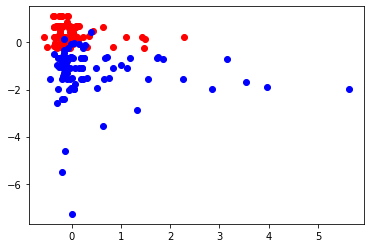

In [14]:
# Basé sur le résultat d'ACP, on effectue le K-means dans le plan (1,2) qui se compose de deux composantes dont inerties les plus élevées 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

kmeans = KMeans(n_clusters=2, random_state=0) # Selon le sujet, ici on ne choisit que de classer en 2 clusters.
labels = kmeans.fit_predict(coord[:,[0,1]]) # on ne prend que les coordonées de l'axe 1 et 2

print(np.unique(labels, return_counts=True)) # afficher la condition de séparation

labels0 = coord[labels == 0]
labels1 = coord[labels == 1]
plt.scatter(np.random.choice(labels0[:,0],100), np.random.choice(labels0[:,1],100), c='red') # Pour voir plus clairement, on prend aléatoirement 100 points pour tracer le graphique
plt.scatter(np.random.choice(labels1[:,0],100), np.random.choice(labels1[:,1],100), c='blue') 


In [15]:
# Avant de passer à l'approche supervisée, il faut d'abord labeliser les données
# Dans cette étape on va utiliser un échantillon de taille 50000 pour entraîner le modèle
# Comme on a 4 indicateurs, on décide de les combiner en utilisant la méthode d'entropie

In [16]:
# Méthode d'entropie

data = features.iloc[:,[1,2,3,4]]
indicateur = data.columns.tolist()   ## nombre des indicateurs
profil = data.index.tolist()    ## nombre des profils
value = data.values

# définir la fonction de normalisation, on rajoute une constante 0,01
def std_data(value,flag):
    for i in range(len(indicateur)):
        if flag[i]=='+':
            value[:,i]=(value[:,i]-np.min(value[:,i],axis=0))/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
        elif flag[i]=='-':
            value[:,i]=(np.max(value[:,i],axis=0)-value[:,i])/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
    return value

# définir la fonction d'entropie et calculer les poids et les entropies
def cal_weight(indicateur,profil,value):
    p= np.array([[0.0 for i in range(len(indicateur))] for i in range(len(profil))])                    
    for i in range(len(indicateur)):
        p[:,i]=value[:,i]/np.sum(value[:,i],axis=0)
        
    e=-1/np.log(len(profil))*sum(p*np.log(p))      #calcul d'entropie
    g=1-e     
    w=g/sum(g)     #calcul des poids
    return w

# normalisation des données
flag=["+","+","+","+"]  ## '+' ou '-' désigne le sens positif ou négatif des indicateurs
std_value=std_data(value,flag)
std_value.round(3)

# Résultat
w=cal_weight(indicateur,profil,std_value)
w=pd.DataFrame(w,index=data.columns,columns=['Poids'])
print("#######Poids:#######")
print(w)
score=np.dot(std_value,w).round(2)
score=pd.DataFrame(score,index=data.index,columns=['Notes']).sort_values(by =['Notes'],ascending = False)

# la note de chaque utilisateur représente la correspondance avec les profils qu'on va détecter
# Si une note plus élevée, le profil correspondant est plus probablement censé un influnceur

#######Poids:#######
                 Poids
vis           0.528325
r_fri_follow  0.009407
avg_fav       0.030440
frequency     0.431829


In [17]:
# A l'aide de résultat ci-dessus, on peut compter la fréquence de chaque note. Avec cela, on va ensuite calculer
# le pourcentage de fréquence cumulée. En vertu de principe de Pareto (80/20), on peut alors découper les données en 2 classes:
# les profils plus générals (la somme de fréquence représente environ 80% au total) et le reste plus critique (20%)

In [18]:
import collections
data1 = []
for i in range(266203):
    data1.append(score.iloc[i,0])

c = collections.Counter(data1) #créer un counter pour compter la fréquence de note

freq = np.array(list(dict(c).items()),dtype = 'float')
np.set_printoptions(suppress=True)
freq = freq[np.lexsort(-freq.T)] # ordonner par décroissant en fonction de fréquence

somme = 0
cumul = 0.00
cluster = []

for i in range(len(data)):
    if cumul <= 0.81:          # 0.01 de tolérance 
        somme = somme + freq[i,1].astype(int)
        cluster.append(freq[i,0])
        cumul = somme/len(score)
    else: break
    
print(cumul) # le pourcentage cumulé pour la classe 'générale'
print(cluster) #les notes de cette classe

0.8131207645264534
[0.05, 0.03, 0.07, 0.09, 0.01, 0.06, 0.04]


In [19]:
# On va maintenant labeliser les profils en fonction de classes divisées ci-dessus
label = score.apply(lambda row: -1 if row["Notes"] in cluster else 1, axis=1 )
label

206032    1
53587     1
74553     1
113072    1
57479     1
         ..
85287    -1
28581    -1
155302   -1
189461   -1
246750   -1
Length: 266204, dtype: int64

In [21]:
# Application de la méthode SVM
data = features_normalized
data["label"] = label
data = data.sample(20000) # On prend un échantillon de taille 50000

X = data.iloc[:,[0,1,2,3]]
Y = data.iloc[:,[4]]
X = X.to_numpy()
Y = Y.to_numpy().T[0]

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                    test_size=0.3, random_state=42) # On sépare les jeux d'entrâinement et de test         


parameters = {'C':[0.001],
              'kernel':['rbf'], 
             'gamma':[0.001,0.1],
              'decision_function_shape':['ovo'],
              
             }
svm_clf = svm.SVC()
#svm_clf = svm.SVC()
#svm_clf.fit(X_train, y_train)

clf = GridSearchCV(svm_clf, parameters)
clf.fit(X_train, y_train)

a=pd.DataFrame(clf.cv_results_)
a.sort_values(['mean_test_score'],ascending=False)
clf.best_estimator_,clf.best_score_

prediction1 = svm_clf.predict(X_test)
print(accuracy_score(y_test,prediction1),'\n',classification_report(y_test,prediction1))

(SVC(C=0.001, decision_function_shape='ovo', gamma=0.001), 0.8095714285714285)

Confusion Matrix: 
[[4894    0]
 [   0 1106]]


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (266204).

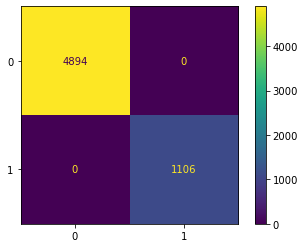

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_test, y_pred=y_test)
print("Confusion Matrix: ")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot()
plt.show()